# Stage II dataset construction

Now we need to combine the fragment class probabilities coming from each stage I classifier into into a single prediction for each fragment.

To help with thinking about the problem, let's draw a diagram for the first three stage I length bins:

```text

Fragment length (words): 1   5   10  15  25  30  35  40  45  50  55  60  65  70  75  80  85  90  95  100 105
                         +---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+
            bin 001-050: |1                                50|                   |                   |
                         +-----------------------------------+                   |                   |
            bin 026-075:                  |26                                  75|                   |
                                          +--------------------------------------+                   |
            bin 051-100:                                      |51                                 100|
                                                              +--------------------------------------+
```

Ignoring the start and end of the range where we will have some fragments that are only scored by one classifier, the solution is easy, the stage II classifier is a second set of models which each take a length range equal to one of the overlaps between the stage I bins. So for example, here's how it would work for a fragment of length 36:

1. Fragment gets scored by stage I bin 001-050 classifier.
2. Fragment gets scored by stage I bin 026-075 classifier.
3. Score from each classifier becomes new feature, maybe 'short score' and 'long score' or something similar.
4. Dual scored fragment is sent to a second stage '26-50' classifier that takes all of the features, including the short and long scores from the stage I classifiers, to predict a final class probability. Bang. Done.

Edge cases are fragments that are below 26 words or above 275 words. These are only scored by a single stage I classifier. These fragments could either be called by their stage I class probability prediction, or go through a stage II classifier designated for them specifically which takes one class probability rather than two. For 'too long' fragments, it's would also be possible to split and/or sample from them, something like that. Easy.

## 1. Run setup

In [1]:
# Change working directory to parent so we can import as we would from main.py
print(f'Working directory: ', end = '')
%cd ..

import h5py
import pickle
import pandas as pd

from scipy.stats import uniform, randint
from sklearn.metrics import make_scorer

import configuration as config
import functions.kullback_leibler_divergence as kld_funcs
import functions.notebook_helper as helper_funcs
import functions.notebook_plotting as plot_funcs
import functions.length_binned_xgboost as xgb_funcs

Working directory: /mnt/arkk/llm_detector/classifier


Set some run parameters and decide whether to run or load data for each experiment:

In [2]:
# Base dataset name
dataset_name = 'falcon-7b_scores_v2_10-300_words_stage_I'

# Construct input/output filepaths
input_file = f'{config.DATA_PATH}/{dataset_name}.h5'
output_file = f'{config.DATA_PATH}/{dataset_name}_stage_II.h5'

# New stage II bins
bins = {
    'bin_026_050': [26, 50],
    'bin_051_075': [51, 75],
    'bin_076_100': [76, 100],
    'bin_101_125': [101, 125],
    'bin_126_150': [126, 150],
    'bin_151_175': [151, 175],
    'bin_176_200': [176, 200],
    'bin_201_225': [201, 225],
    'bin_226_250': [226, 250],
    'bin_251_275': [251, 275]
}

# Number of hyperparameter combinations to sample during optimization
hyperparameter_iterations = 100

# Paths to save and load results
stage_one_hyperparameter_optimization_results_filename = f'{config.DATA_PATH}/stage_one_hyperparameter_optimization_results_{hyperparameter_iterations}_iterations.pkl'

## 2. Stage I class probabilities feature addition

In [3]:
%%time

# Score each fragment and add the stage I classifier probabilities
# as a new feature
_ = xgb_funcs.add_stage_one_probabilities_features(
    input_file,
    output_file,
    stage_one_hyperparameter_optimization_results_filename
)

# Check the result

# Open a connection to the hdf5 dataset via PyTables with Pandas
data_lake = pd.HDFStore(output_file)

# Load the combined features
features_df = data_lake['training/combined/features']

# Close the connection
data_lake.close()

features_df.head()
features_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 3904 entries, 0 to 3903
Data columns (total 14 columns):
 #   Column                                              Non-Null Count  Dtype  
---  ------                                              --------------  -----  
 0   Fragment length (words)                             3904 non-null   int64  
 1   Fragment length (tokens)                            3904 non-null   int64  
 2   Source                                              3904 non-null   object 
 3   String                                              3904 non-null   object 
 4   Perplexity                                          3904 non-null   float64
 5   Cross-perplexity                                    3904 non-null   float64
 6   Perplexity ratio score                              3904 non-null   float64
 7   Perplexity ratio score Kullback-Leibler divergence  3904 non-null   float64
 8   Human TF-IDF                                        3904 non-null   float64
 9   Sy

OK, cool. Looks good. The stage II dataset now has one bin, 'combined' which has the new short and long score features from the stage I classifiers. To finish the stage II dataset we need to re-bin the data with a new set of bins which correspond to the overlaps of the stage I bins.

## 2. Stage II data binning

In [5]:
%%time

# Open the new hdf5 file with pandas so we can work with dataframes
data_lake = pd.HDFStore(output_file)

# Load the combined training and testing data
training_df = data_lake['training/combined/features']
testing_df = data_lake['testing/combined/features']

# Drop the features that we are going to recalculate
feature_drops = [
    'Perplexity ratio score Kullback-Leibler divergence',
    'Human TF-IDF',
    'Synthetic TF-IDF',
    'TF-IDF score',
    'TF-IDF score Kullback-Leibler divergence'
]

training_df.drop(feature_drops, axis = 1, inplace = True)
testing_df.drop(feature_drops, axis = 1, inplace = True)

# Drop any data that contains nan
training_df.dropna(inplace = True)
testing_df.dropna(inplace = True)

training_df.info()

# Loop on the bins to bin the data
for bin_id, bin_range in bins.items():

    # Pull the fragments for this bin
    bin_training_df = training_df[(training_df['Fragment length (words)'] >= bin_range[0]) & (training_df['Fragment length (words)'] <= bin_range[1])]
    bin_testing_df = testing_df[(testing_df['Fragment length (words)'] >= bin_range[0]) & (testing_df['Fragment length (words)'] <= bin_range[1])]

    # Fix the index
    bin_training_df.reset_index(inplace = True, drop = True)
    bin_testing_df.reset_index(inplace = True, drop = True)

    # Get bin labels
    bin_training_labels, bin_testing_labels = helper_funcs.make_labels(bin_training_df, bin_testing_df)

    # Add the data to the data lake
    data_lake.put(f'training/{bin_id}/features', bin_training_df)
    data_lake.put(f'training/{bin_id}/labels', bin_training_labels)
    data_lake.put(f'testing/{bin_id}/features', bin_training_df)
    data_lake.put(f'testing/{bin_id}/labels', bin_training_labels)

data_lake.close()

# Finally, add the bins as metadata
data_lake = h5py.File(output_file, 'a')
data_lake.attrs.update(bins)
data_lake.close()

<class 'pandas.core.frame.DataFrame'>
Index: 3360 entries, 0 to 3903
Data columns (total 9 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Fragment length (words)   3360 non-null   int64  
 1   Fragment length (tokens)  3360 non-null   int64  
 2   Source                    3360 non-null   object 
 3   String                    3360 non-null   object 
 4   Perplexity                3360 non-null   float64
 5   Cross-perplexity          3360 non-null   float64
 6   Perplexity ratio score    3360 non-null   float64
 7   Short score               3360 non-null   float64
 8   Long score                3360 non-null   float64
dtypes: float64(5), int64(2), object(2)
memory usage: 262.5+ KB
CPU times: user 388 ms, sys: 28.2 ms, total: 417 ms
Wall time: 700 ms


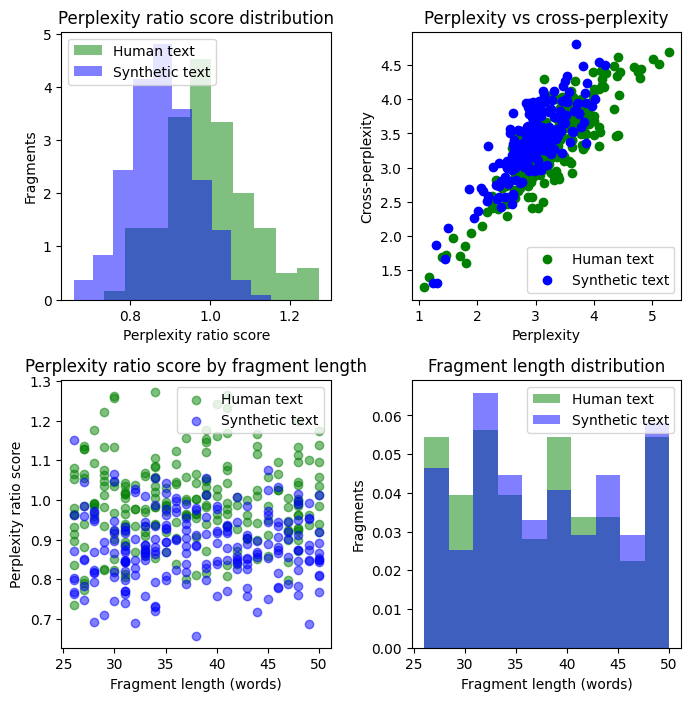

In [6]:
# Makes some plots with some of the binned data to check it for sanity

# Open a connection to the hdf5 dataset via PyTables with Pandas
data_lake = pd.HDFStore(output_file)

# Pull the training features from one of the bins
bin_training_features_df = data_lake[f'training/bin_026_050/features']
data_lake.close()

# Make the plots
plot_funcs.data_exploration_plot(bin_training_features_df).show()

## 3. Feature re-engineering
### 3.1. Perplexity ratio

In [7]:
%%time

input_file = f'{config.DATA_PATH}/{dataset_name}_stage_II.h5'

# Run part I of the workflow in parallel over the bins - gets kernel density estimate
# of Kullback-Leibler divergence between the feature's distribution for human and
# synthetic text fragments in the training data, saves to disk for later use.

kld_funcs.get_kullback_leibler_kdes(
    feature_name = 'Perplexity ratio score',
    hdf5_file = input_file,
    logfile_name = 'perplexity_ratio_KLD_KDE.log'
)

Will log to: /mnt/arkk/llm_detector/classifier/logs/perplexity_ratio_KLD_KDE.log

bin_026_050 finished: True
bin_051_075 finished: True
bin_076_100 finished: True
bin_101_125 finished: True
bin_126_150 finished: True
bin_151_175 finished: True
bin_176_200 finished: True
bin_201_225 finished: True
bin_226_250 finished: True
bin_251_275 finished: True
CPU times: user 280 ms, sys: 375 ms, total: 655 ms
Wall time: 1.79 s


In [8]:
%%time

# Run part II of the workflow described above - uses previously stored
# kernel density estimates of the Kullback-Leibler divergence between
# the perplexity ratio scores for human and synthetic text fragments
# in each bin. Loads the data from each bin sequentially and evaluates
# each text fragment's perplexity ratio score. Parallelizes evaluation
# over data in the bin. Adds result back to hdf5 as new feature column.

kld_funcs.make_kullback_leibler_feature(
    feature_name = 'Perplexity ratio score',
    hdf5_file = input_file,
    logfile_name = 'perplexity_ratio_KLD_feature_addition.log'
)

Will log to: /mnt/arkk/llm_detector/classifier/logs/perplexity_ratio_KLD_feature_addition.log

bin_026_050 finished: True
bin_051_075 finished: True
bin_076_100 finished: True
bin_101_125 finished: True
bin_126_150 finished: True
bin_151_175 finished: True
bin_176_200 finished: True
bin_201_225 finished: True
bin_226_250 finished: True
bin_251_275 finished: True
CPU times: user 7.12 s, sys: 10.7 s, total: 17.8 s
Wall time: 44.4 s


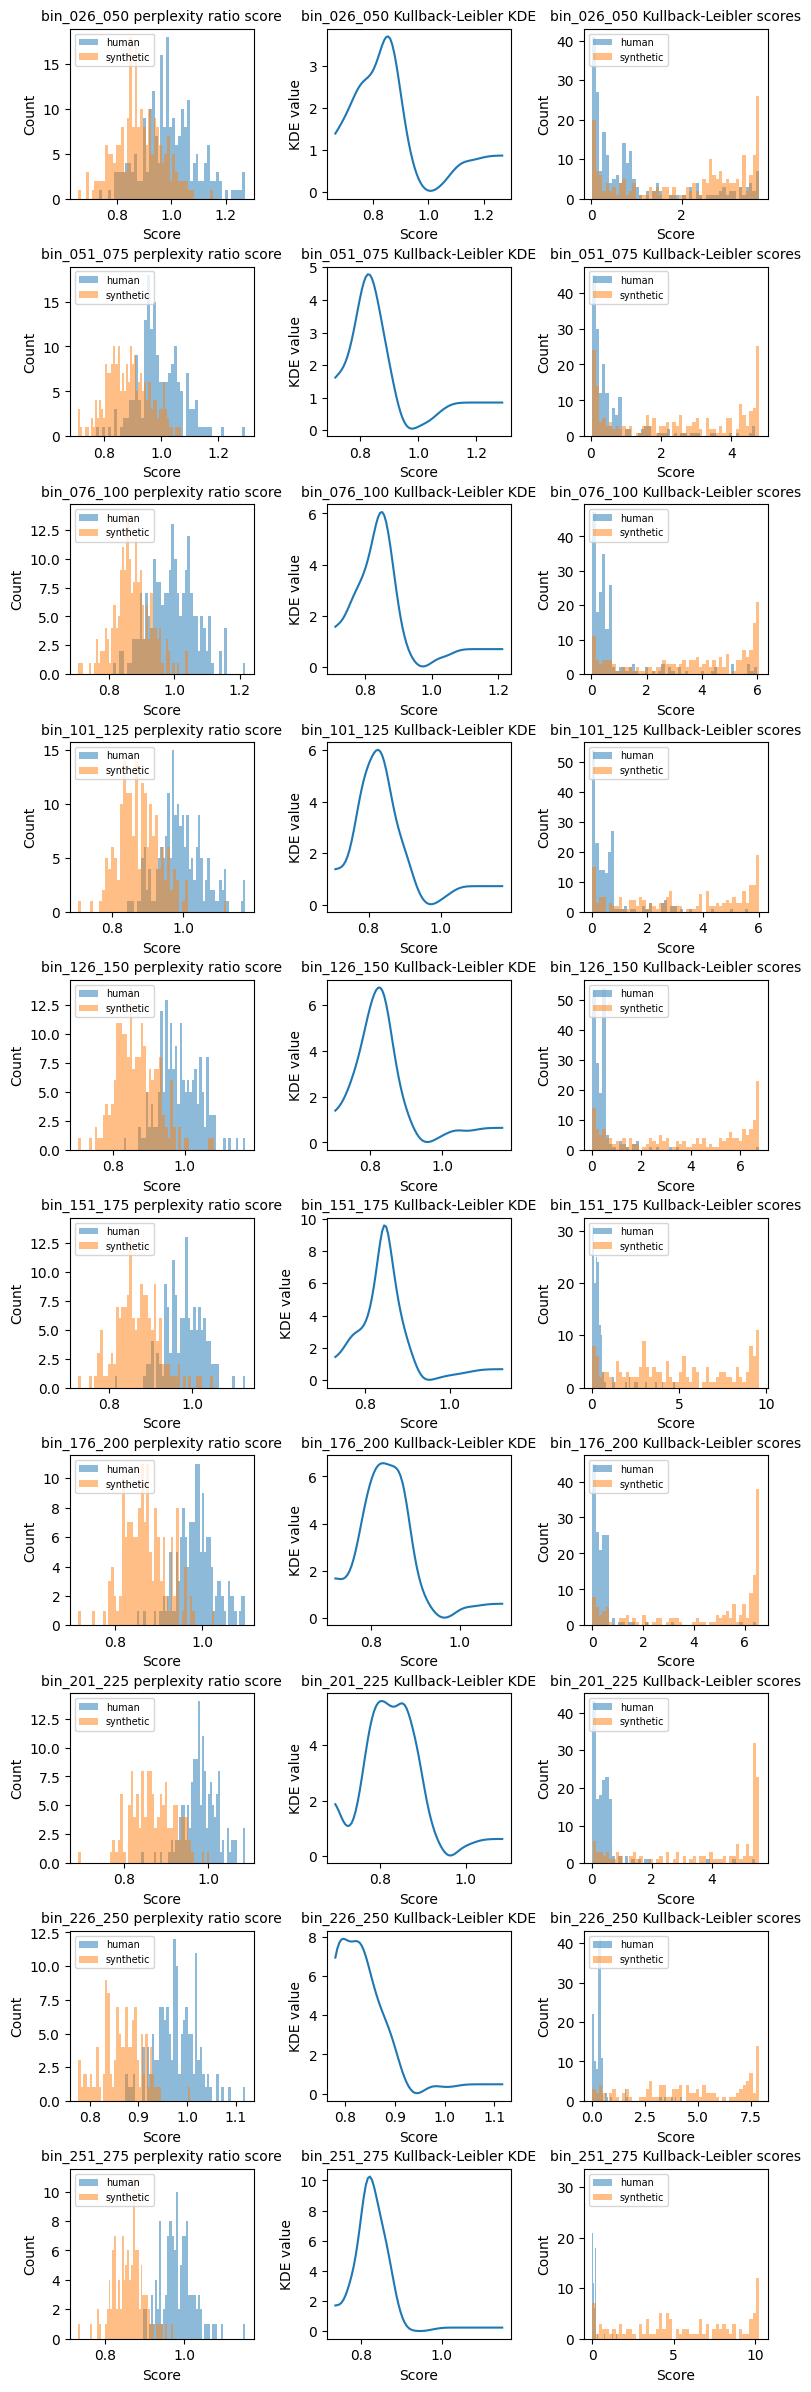

In [9]:
kld_funcs.plot_results(
    hdf5_file = input_file, 
    feature_name = 'Perplexity ratio score'
).show()

### 3.2. TF-IDF score

In [10]:
import functions.tf_idf_score as tf_idf_funcs

In [11]:
%%time

# Calculate TF-IDF scores for all of the fragments
tf_idf_funcs.tf_idf_score(
    hdf5_file = input_file,
    score_sample = False,
    logfile_name = 'TF-IDF_score.log'
)

Will log to: /mnt/arkk/llm_detector/classifier/logs/TF-IDF_score.log
CPU times: user 622 ms, sys: 419 ms, total: 1.04 s
Wall time: 5.32 s


In [12]:
%%time

# Run part I of the workflow in parallel over the bins - gets kernel density estimate
# of Kullback-Leibler divergence between the feature's distribution for human and
# synthetic text fragments in the training data, saves to disk for later use.

kld_funcs.get_kullback_leibler_kdes(
    feature_name = 'TF-IDF score',
    hdf5_file = input_file,
    logfile_name = 'TF-IDF_KLD_KDE.log'
)

Will log to: /mnt/arkk/llm_detector/classifier/logs/TF-IDF_KLD_KDE.log

bin_026_050 finished: True
bin_051_075 finished: True
bin_076_100 finished: True
bin_101_125 finished: True
bin_126_150 finished: True
bin_151_175 finished: True
bin_176_200 finished: True
bin_201_225 finished: True
bin_226_250 finished: True
bin_251_275 finished: True
CPU times: user 254 ms, sys: 560 ms, total: 814 ms
Wall time: 1.49 s


In [13]:
%%time

# Run part II of the workflow described above - uses previously stored
# kernel density estimates of the Kullback-Leibler divergence between
# the TF-IDF scores for human and synthetic text fragments
# in each bin. Loads the data from each bin sequentially and evaluates
# each text fragment's TF-IDF score. Parallelizes evaluation
# over data in the bin. Adds result back to hdf5 as new feature column.

kld_funcs.make_kullback_leibler_feature(
    feature_name = 'TF-IDF score',
    hdf5_file = input_file,
    logfile_name = 'TF-IDF_KLD_feature_addition.log'
)

Will log to: /mnt/arkk/llm_detector/classifier/logs/TF-IDF_KLD_feature_addition.log

bin_026_050 finished: True
bin_051_075 finished: True
bin_076_100 finished: True
bin_101_125 finished: True
bin_126_150 finished: True
bin_151_175 finished: True
bin_176_200 finished: True
bin_201_225 finished: True
bin_226_250 finished: True
bin_251_275 finished: True
CPU times: user 2.63 s, sys: 6.38 s, total: 9 s
Wall time: 26.4 s


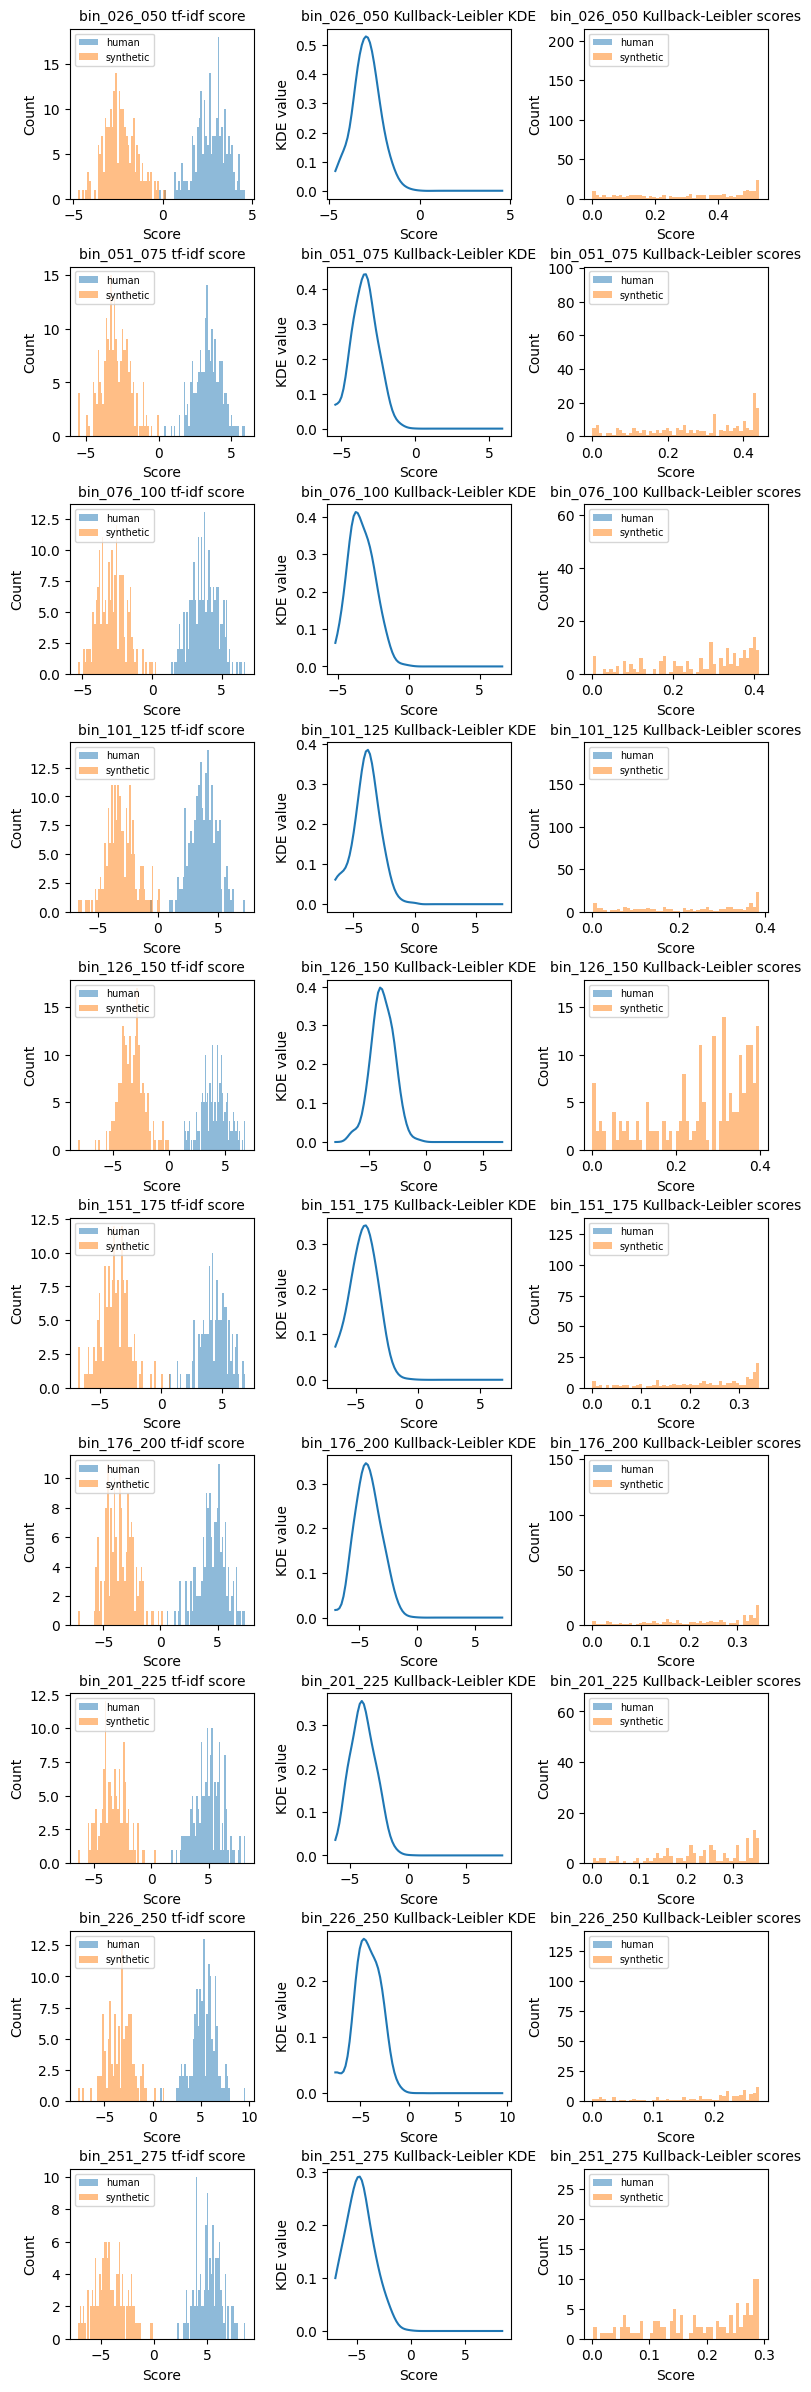

In [14]:
kld_funcs.plot_results(
    hdf5_file = input_file, 
    feature_name = 'TF-IDF score'
).show()